# Whole Slide Data Tutorial & Examples

The wholeslidedata package aims to provide the tools to work with whole-slide images and annotations from different vendors and annotation software. The main contribution is a batch iterator that enables users to sample patches from the data efficiently, fast, and easily.

In [1]:
#install the whole slide data package
#!pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main

In [ ]:
import os
print(f"Previous exec path: {os.getcwd()}")
# move two level up
os.chdir('../../')
print(f"Current exec path: {os.getcwd()}")

Previous exec path: /workspace/source/notebooks
Current exec path: /workspace


## Whole Slide Image

In [3]:
# issue fix with openslide bin path
import sys

# Path to ASAP binaries
asap_bin_path = "/opt/ASAP/bin"

# Append to system PATH
os.environ["PATH"] += os.pathsep + asap_bin_path

# Verify it's in the PATH
print("ASAP Path added to PATH:", asap_bin_path)

ASAP Path added to PATH: /opt/ASAP/bin


In [4]:
# Add ASAP Python library path
asap_python_lib_path = "/opt/ASAP/lib/python3.8/site-packages"
sys.path.append(asap_python_lib_path)

# Verify it's in sys.path
print("ASAP Python library path added:", asap_python_lib_path)

ASAP Python library path added: /opt/ASAP/lib/python3.8/site-packages


In [5]:
from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.openslide.backend import OpenSlideWholeSlideImageBackend

import numpy as np

from matplotlib import pyplot as plt
plt.rc('font', size=12) 

In [6]:
TEST_DATA_BASE_PATH = "./data/test"
test_wsi_path = os.path.join(TEST_DATA_BASE_PATH,"input", "A_P000002_PAS_CPG.tif")
test_wsa_path = os.path.join(TEST_DATA_BASE_PATH,"ground_truth", "A_P000002_polygon.xml")
roi_maks_path = os.path.join(TEST_DATA_BASE_PATH,"input", "A_P000002_mask.tif")

In [7]:
wsi = WholeSlideImage(path=test_wsi_path, 
                      backend=OpenSlideWholeSlideImageBackend)
spacing = 0.25 # micrometer/pixel resolution
real_spacing = wsi.get_real_spacing(spacing) #try to get the real spacing as close as possible to the desired spacing (micrometer/pixel)
shape = wsi.get_shape_from_spacing(spacing)

downsampling = wsi.get_downsampling_from_spacing(spacing)

In [8]:
print(f'wsi path: {wsi.path}')
print(f'level count: {wsi.level_count}')
print(f'spacings: {wsi.spacings}')
print(f'shapes:  {wsi.shapes}')
print(f'downsamplings: {wsi.downsamplings}')
print(f'closest real spacing to {spacing} = {real_spacing}')
print(f'shape at spacing {spacing} = {shape}')
print(f'downsampling at spacing {spacing} = {downsampling}')

wsi path: ./data/test/input/A_P000002_PAS_CPG.tif
level count: 9
spacings: [0.24199951445730394, 0.4839990289146079, 0.9679980578292158, 1.9359961156584315, 3.871992231316863, 7.743984462633726, 15.487968925267452, 30.975937850534905, 61.95187570106981]
shapes:  ((97536, 89600), (48768, 44800), (24384, 22400), (12192, 11200), (6096, 5600), (3048, 2800), (1524, 1400), (762, 700), (381, 350))
downsamplings: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)
closest real spacing to 0.25 = 0.24199951445730394
shape at spacing 0.25 = (97536, 89600)
downsampling at spacing 0.25 = 1.0


We can quickly visualize the levels of the whole slide image, seeing the correspectice resolution in micro-meter/pixel and other metadatas.
Then whole-slide-data will try to match the required spacing you need to the nearest one of the slide. In this example we used 0.25 micro-meters/pixel (level 0 of the highest zoom) and the real one is 0.24199951445730394.
Finally we can see the downsampling from the lowest level done with the selected spacing (in this case no downsampling is done because we are at max resolution).

We can visualize the slide at the required level with a simple command:

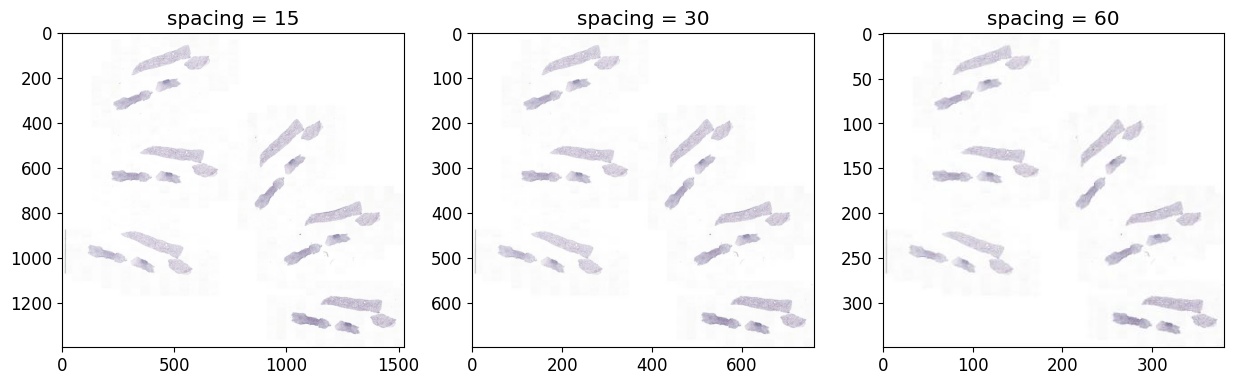

In [9]:
slide_15 = wsi.get_slide(spacing=15)
slide_30 = wsi.get_slide(spacing=30)
slide_60 = wsi.get_slide(spacing=60)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(slide_15)
ax[0].set_title("spacing = 15")
ax[1].imshow(slide_30)
ax[1].set_title("spacing = 30")
ax[2].imshow(slide_60)
ax[2].set_title("spacing = 60")
plt.show()

We can also visualize patches:

In [10]:
x, y = np.round((np.array(wsi.shapes[0]) / 2.2),0)
width, height = 1024, 1024

patch_7 = wsi.get_patch(x=x, y=y, width=width, height=height, spacing=7)
patch_4 = wsi.get_patch(x=x, y=y, width=width, height=height, spacing=4)

We have extracted two patches at spacing (zoom level) 7 and 4 at given coordinates (x,y) with given height and width.

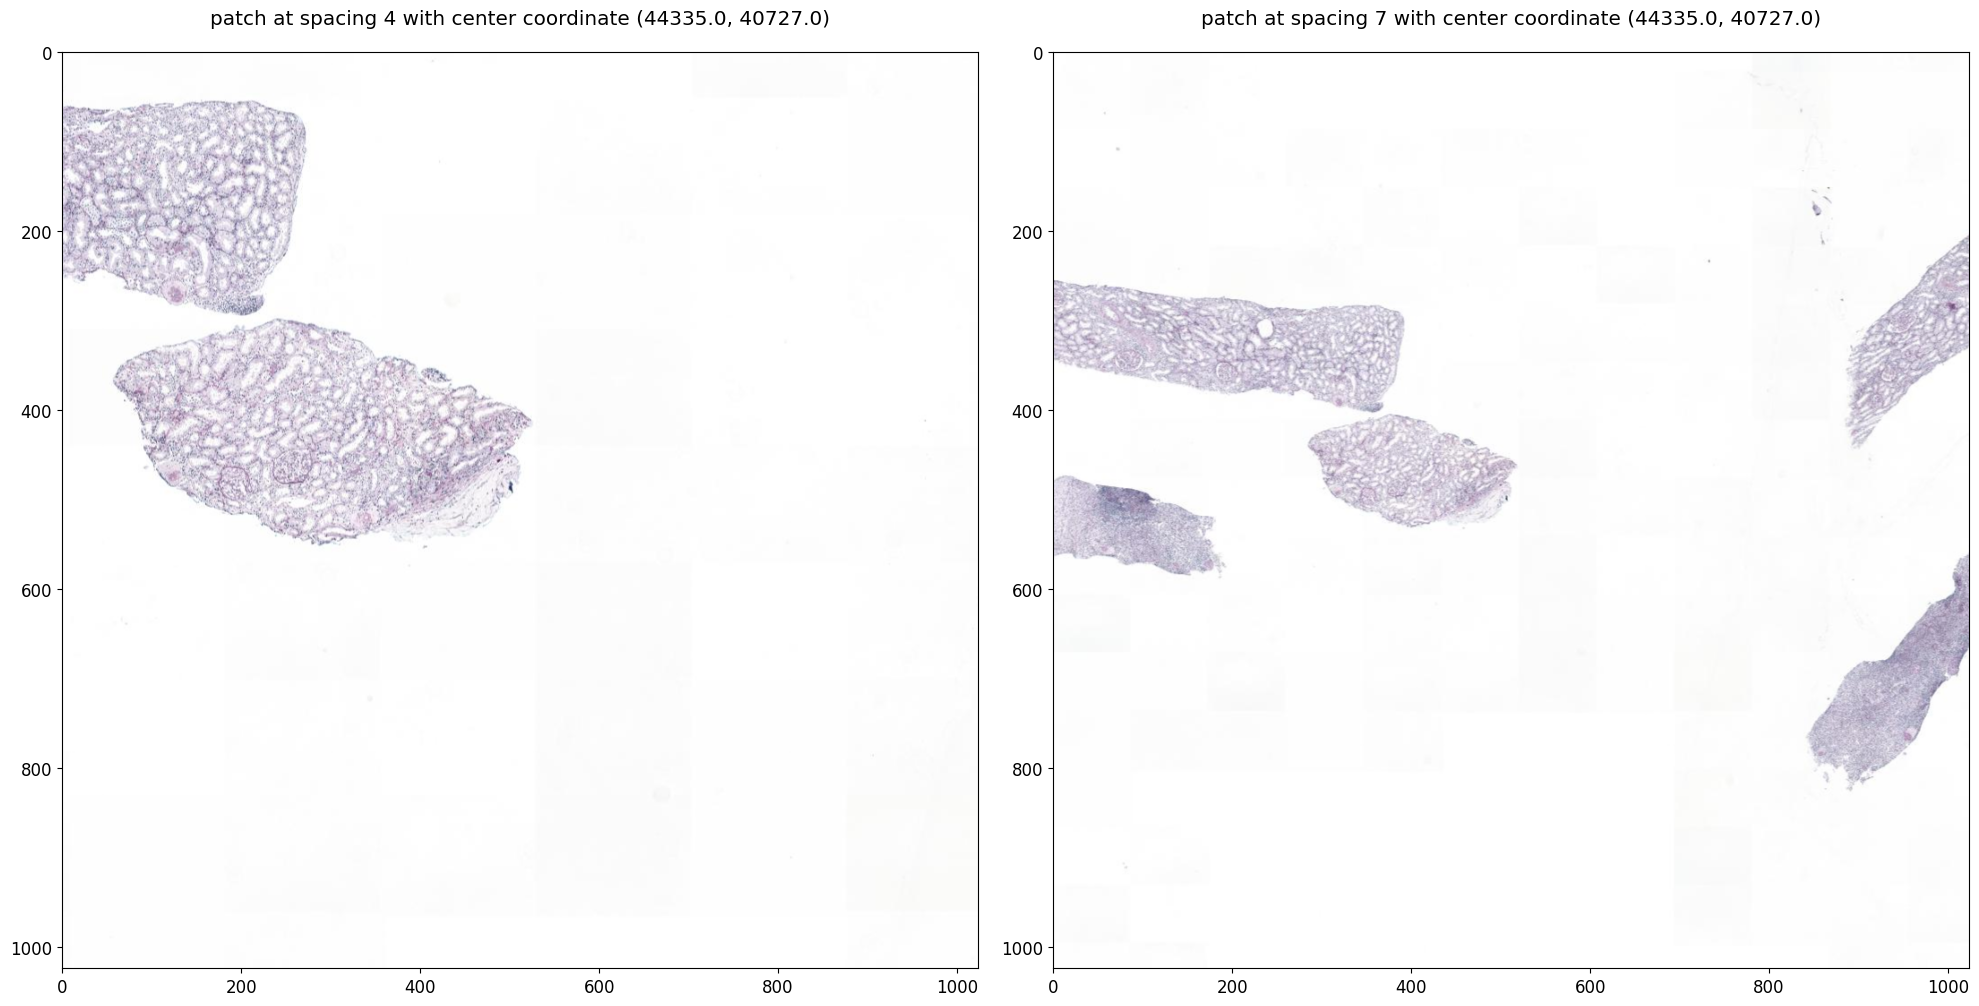

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(patch_4)
axes[0].set_title(f'patch at spacing 4 with center coordinate {x,y}', pad=20)
axes[1].imshow(patch_7)
axes[1].set_title(f'patch at spacing 7 with center coordinate {x,y}', pad=20)
plt.tight_layout()
plt.show()

## Whole Slide Annotation

In [12]:
!pip install colour

In [13]:
from wholeslidedata import WholeSlideAnnotation
from wholeslidedata.visualization.plotting import plot_annotations
from colour import Color
from matplotlib import pyplot as plt

In [14]:
wsa = WholeSlideAnnotation(test_wsa_path)

In [15]:
print(len(wsa.annotations))
print(wsa.labels.names)
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}
print(color_map)

3821
['lymphocytes', 'monocytes', 'roi']
{'lymphocytes': '#237705', 'monocytes': '#009b52', 'roi': '#e404f5'}


Visualizing all the annotations, with associated colors

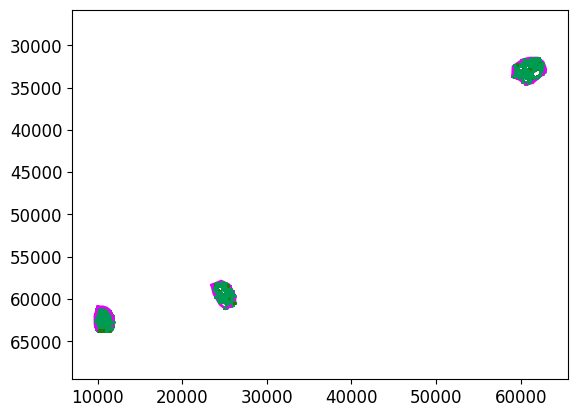

In [16]:
plot_annotations(wsa.annotations, color_map=color_map)

Visualizing only a portion of the wsi with annotations and filtering them

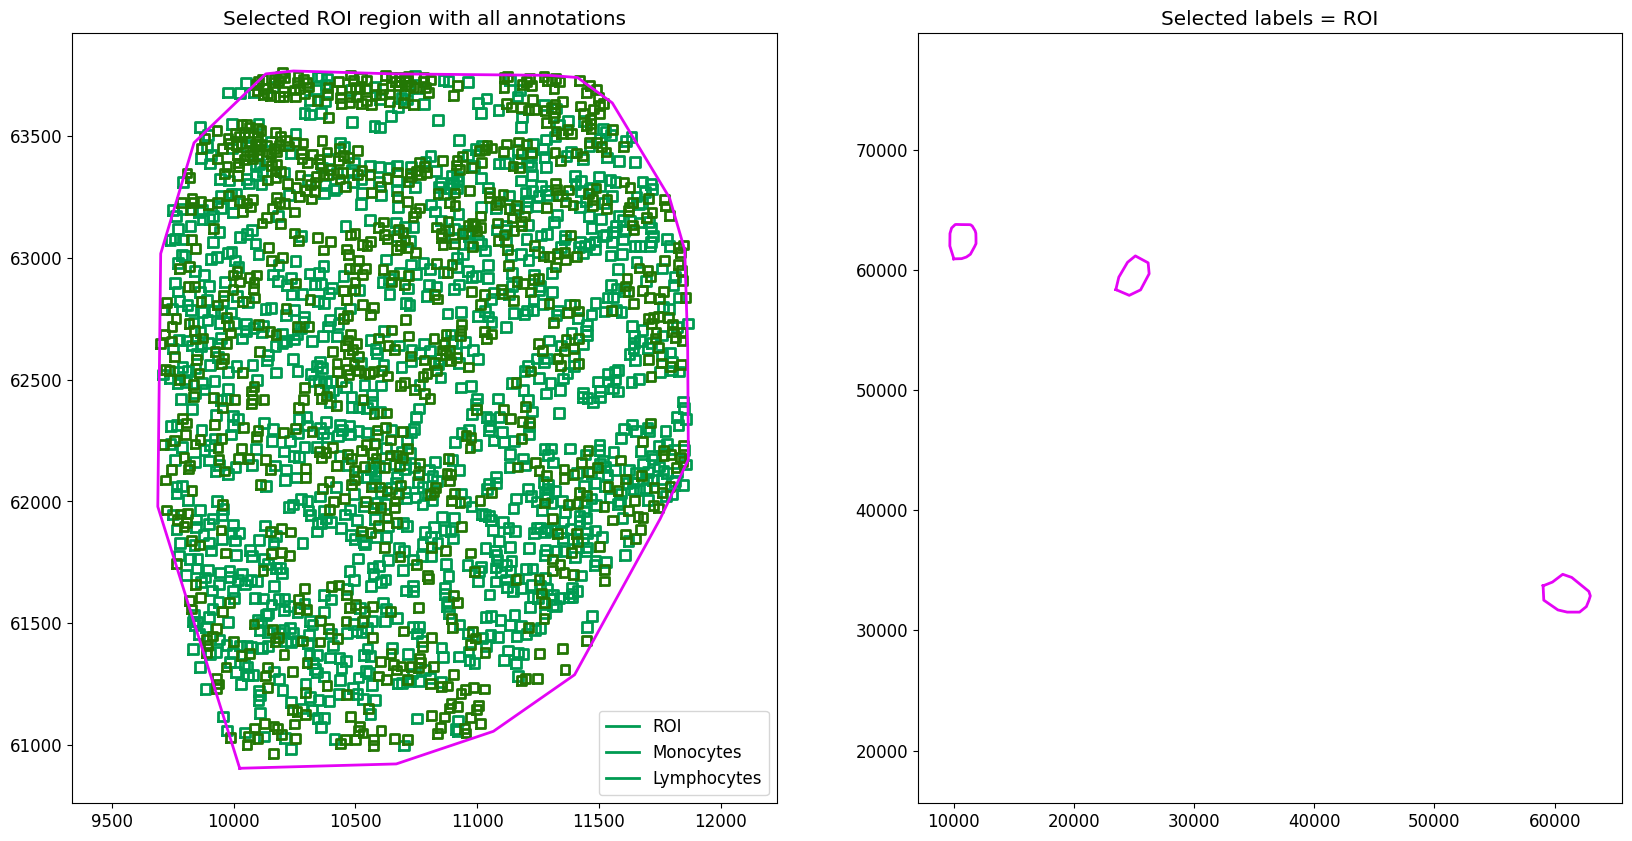

In [17]:
selected_annotations = wsa.select_annotations(center_x=11000, center_y=62500, width=10000, height=10000)
roi_annotations = [annotation for annotation in wsa.annotations if annotation.label.name == "roi"]
fig, axes = plt.subplots(1,2, figsize=(20, 10))
plot_annotations(selected_annotations, ax=axes[0], color_map=color_map)
plot_annotations(roi_annotations, ax=axes[1], color_map=color_map)
axes[0].set_title("Selected ROI region with all annotations")
axes[0].legend(labels={label_name: label_name for label_name in ["ROI", "Monocytes", "Lymphocytes"]})
axes[1].set_title("Selected labels = ROI")
plt.show()

### Aggregating Annotations (!)
We can also aggregate annotations using two labels names dictionaries.

In [18]:
wsa = WholeSlideAnnotation(test_wsa_path)
wsa.labels.names

['lymphocytes', 'monocytes', 'roi']

In [19]:
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}
color_map

{'lymphocytes': '#237705', 'monocytes': '#009b52', 'roi': '#e404f5'}

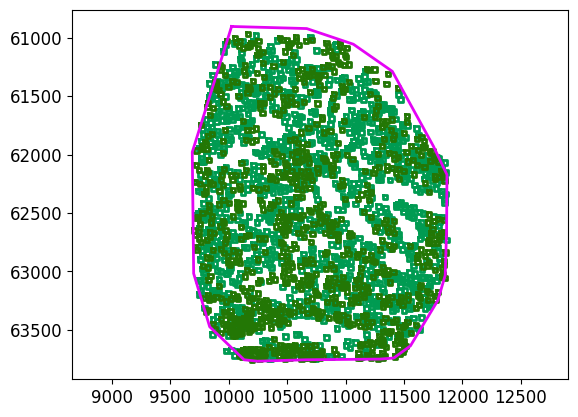

In [20]:
selected_annotations = wsa.select_annotations(center_x=11000, center_y=62500, width=10000, height=10000)
plot_annotations(selected_annotations, color_map=color_map)
plt.show()

In [21]:
labels_original_dict = {'lymphocytes': 0, 'monocytes': 0, 'roi': 1}
print(labels_original_dict)

{'lymphocytes': 0, 'monocytes': 0, 'roi': 1}


In [ ]:
aggregated_labels_dict = {"inflammatory_cells":0, "roi":1}
aggregated_labels_dict

{'inflammatory_cells': 0, 'roi': 1}

In [23]:
wsa = WholeSlideAnnotation(
    test_wsa_path, 
    labels=labels_original_dict,
    renamed_labels=aggregated_labels_dict
    )
print(wsa.labels.names)

['inflammatory_cells', 'roi']


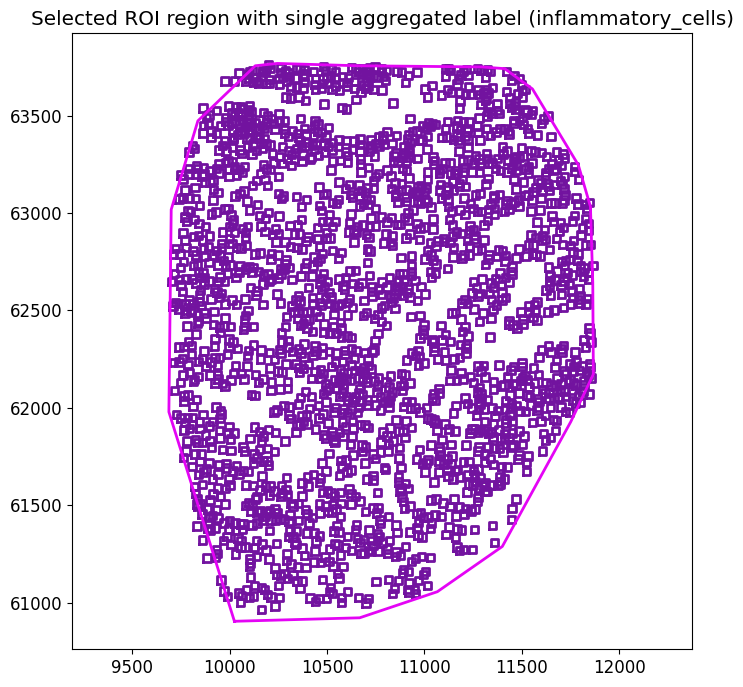

In [24]:
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}
selected_annotations = wsa.select_annotations(center_x=11000, center_y=62500, width=10000, height=10000)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_annotations(selected_annotations, color_map=color_map, ax=ax)
plt.title("Selected ROI region with single aggregated label (inflammatory_cells)")
plt.show()

### Callbacks
Please see [this example](https://diagnijmegen.github.io/pathology-whole-slide-data/userguide/notebooks/components/wholeslideannotation.html#callbacks)!

They can be use to process the Whole Slide Annotations in different ways.
For our annotations it doesn't work like the docs, also they changed the API!

In [25]:
from wholeslidedata.annotation.callbacks import ScalingAnnotationCallback, TiledAnnotationCallback

In [26]:
wsa_path = WholeSlideAnnotation(test_wsa_path)

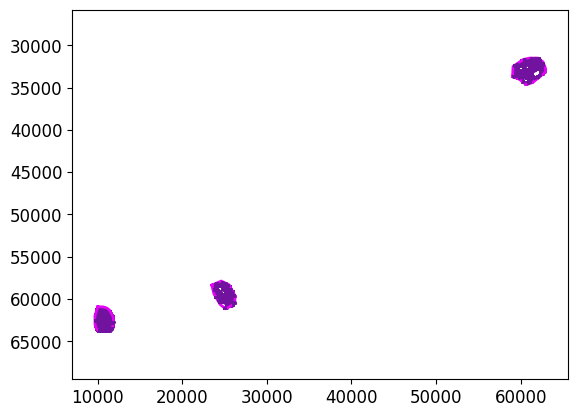

In [27]:
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}

plot_annotations(wsa.annotations, color_map=color_map)

In [28]:
labels = labels_original_dict
wsa = WholeSlideAnnotation(
    test_wsa_path, 
    hooks=(TiledAnnotationCallback(tile_size=256, label_names=list(labels)),))

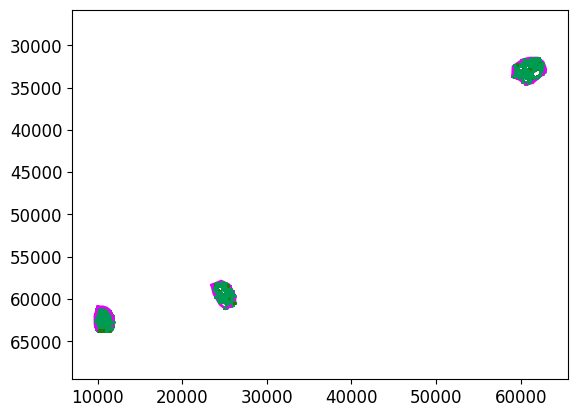

In [29]:
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}
plot_annotations(wsa.annotations, color_map=color_map)

## Batch Iterator
**The BatchIterator is designed to extract patches from Whole Slide Images (WSIs) and their corresponding annotations, in order to generate labeled training data for machine learning models**. The system works by defining a sampling strategy, which involves sampling labels, annotations, and points within the annotations. Based on this strategy, the system selects a patch to extract from the WSI and creates a corresponding label.

### Data Preparation
To prepare the data for sampling, the following steps are taken:

- Associations
    - WSIs and their corresponding annotation files (WSAs) are matched and stored as “associations”.

    - Each association consists of a matched WSI file and WSA file.

    - Each WSI file has an image backend

    - Each WSA file has an annotation parser.

- Parsing annotations: All WSAs are parsed by their annotation parsers to extract a list of annotations (polygons, points).

- Labels: All available labels are gathered from all annotations.

- Annotation mapping: All annotations are mapped to their respective labels.

### Sampling Strategy
The sampling strategy consists of three sampler components:

1. Step 1 - **label_sampler**: samples a label from the available labels.

2. Step 2 - **annotation_sampler**: samples an annotation from the list of annotations that corresponds to the label sampled in step 1.

3. Step 3 - **point_sampler**: samples a point within the annotation sampled in step 2.

### Sampling Data
The data sampling consists of two sampler components

4. Step 4 - **patch_sampler**: selects a patch with a center point based on the point sampled in step 3 of the sampling strategy.

5. Step 5 - **patch_label_sampler**: creates a label (classification, detection, or segmentation) based on the point sampled in step 3 of the sampling strategy.

By repeating the above steps, the BatchIterator generates patches and corresponding labels for use in machine learning models.

In [30]:
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
from dicfg.magics import ConfigMagics

# This will allow loading yaml in an notebook cell
ConfigMagics.register_magics()

### User config file/dictionary
**Configuring the BatchIterator of wholeslidedata requires a configuration file**. While most settings have default values that can be overridden, the data, labels, and batch shape settings must be provided by the user. In the example below, we illustrate how to set these parameters using a YAML configuration file. This YAML file is automatically converted into a Python dictionary called “user_config” using the “yaml” magic function. It is important to note that “user_config” can also be a path to a YAML/JSON file or a pre-existing Python dictionary.

In [31]:
from wholeslidedata.interoperability.pytorch.iterator import WholeSlidePyTorchBatchIterator

from pprint import pprint

In [32]:
print(test_wsi_path)
print(test_wsa_path)

./data/test/input/A_P000002_PAS_CPG.tif
./data/test/ground_truth/A_P000002_polygon.xml


In [33]:
%%yaml config
training:
  - wsi:
      path: ./data/test/input/A_P000002_PAS_CPG.tif
    wsa:
      path: ./data/test/ground_truth/A_P000002_polygon.xml

In [34]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': config, # also the path of the yaml associating wsa and wsi can be used (see training example code of the challenge)
            "seed": 42,
            "image_backend": "openslide", #was asap
            'labels': {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2
            },

            'batch_shape': {
                'batch_size': 4,
                'spacing': 0.5,
                'shape': [128, 128, 3],
                'y_shape': [1000, 6],
            },

            "annotation_parser": {
                "sample_label_names": ['roi'], #this is the label that will be used to sample the patches, so the other regions outside the roi will be ignored
            },

            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
            },

            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 1000,
                "detection_labels": ['lymphocytes', 'monocytes'],

            },

        }
    }
}

In [35]:
with create_batch_iterator(
    user_config=user_config, 
    mode='training',
    # cpu=1,
    # iterator_class = WholeSlidePyTorchBatchIterator()
    ) as training_batch_generator:
    
    batch_dict =  next(training_batch_generator)
    
    pprint(batch_dict)
    
    x_batch, y_batch, info = batch_dict

[array([[[[243, 235, 248],
         [233, 225, 238],
         [213, 205, 220],
         ...,
         [247, 247, 255],
         [251, 250, 255],
         [252, 251, 255]],

        [[254, 246, 255],
         [251, 243, 255],
         [240, 232, 245],
         ...,
         [244, 247, 255],
         [249, 252, 255],
         [251, 252, 255]],

        [[248, 241, 249],
         [249, 241, 252],
         [250, 240, 251],
         ...,
         [234, 238, 250],
         [242, 246, 255],
         [247, 250, 255]],

        ...,

        [[195, 181, 198],
         [209, 194, 213],
         [209, 194, 217],
         ...,
         [192, 173, 195],
         [199, 181, 203],
         [208, 193, 212]],

        [[226, 212, 229],
         [225, 210, 229],
         [213, 198, 221],
         ...,
         [186, 167, 189],
         [202, 184, 206],
         [212, 197, 216]],

        [[232, 218, 235],
         [224, 209, 228],
         [217, 202, 225],
         ...,
         [193, 174, 196],
       

x_batch shape: (4, 128, 128, 3)
y_batch shape: (4, 1000, 6)
info:
{'index': 0,
 'mode': 'training',
 'sample_references': [{'point': (61224.70324534044, 33460.01239362448),
                        'reference': WholeSlideSampleReference(file_index=0, file_key='0', wsa_index=0, annotation_index=3586)},
                       {'point': (24955.259424121883, 60072.267702191515),
                        'reference': WholeSlideSampleReference(file_index=0, file_key='0', wsa_index=0, annotation_index=3587)},
                       {'point': (10975.55595060992, 63147.647087620346),
                        'reference': WholeSlideSampleReference(file_index=0, file_key='0', wsa_index=0, annotation_index=3588)},
                       {'point': (11711.754787217422, 62620.72606749739),
                        'reference': WholeSlideSampleReference(file_index=0, file_key='0', wsa_index=0, annotation_index=3588)}]}


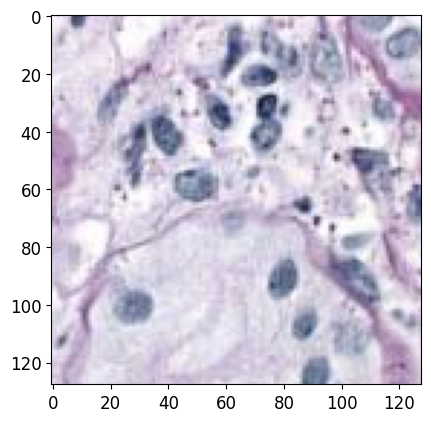

In [36]:
# x_batch = x_batch.transpose(0,3,1,2) # for pytorch!
print(f'x_batch shape: {x_batch.shape}')
print(f'y_batch shape: {y_batch.shape}')
print(f'info:')
pprint(info)


plt.imshow(x_batch[0])
plt.show()

## Patch Iterator

In [37]:
from wholeslidedata.iterators import create_patch_iterator, PatchConfiguration

In [38]:
patch_configuration = PatchConfiguration(patch_shape=(512,512,3),
                                         spacings=(0.5,),
                                         overlap=(0,0),
                                         offset=(0,0),
                                         center=False)

with create_patch_iterator(image_path=test_wsi_path,
                           patch_configuration=patch_configuration,
                           cpus=4,
                           backend='openslide') as patch_iterator:
    
    print(f"Number of patches {len(patch_iterator)}\n")
    for idx, (patch, info) in enumerate(patch_iterator):
        print(f"Index : {idx}, \n Patch shape: {patch.shape}, \n Info : {info}\n")

Number of patches 8448

Index : 0, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 0, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 1, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 1024, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 2, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 2048, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 3, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 3072, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 4, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 4096, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 5, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 5120, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 6, 
 Patch shape: (1, 1, 512, 512, 3), 
 Info : {'x': 6144, 'y': 0, 'tile_shape': (512, 512, 3), 'spacings': (0.5

### Patch Iterator filtering patches with Masks

In [39]:
patch_configuration = PatchConfiguration(patch_shape=(512,512,3),
                                         spacings=(0.5,),
                                         overlap=(0,0),
                                         offset=(0,0),
                                         center=False)

with create_patch_iterator(image_path=test_wsi_path,
                           mask_path=roi_maks_path,
                           patch_configuration=patch_configuration,
                           cpus=4,
                           backend='asap') as patch_iterator:
    
    print(f"Number of patches {len(patch_iterator)}\n")
    for idx, (patch, mask, info) in enumerate(patch_iterator):
        print(f"Index : {idx}, \n Patch shape: {patch.shape}, \n Mask shape: {mask.shape}, \n Info : {info}\n")

Number of patches 42

Index : 0, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512), 
 Info : {'x': 59392, 'y': 30720, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 1, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512), 
 Info : {'x': 60416, 'y': 30720, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 2, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512), 
 Info : {'x': 61440, 'y': 30720, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 3, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512), 
 Info : {'x': 58368, 'y': 31744, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 4, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512), 
 Info : {'x': 59392, 'y': 31744, 'tile_shape': (512, 512, 3), 'spacings': (0.5,), 'center': False}

Index : 5, 
 Patch shape: (1, 1, 512, 512, 3), 
 Mask shape: (1, 1, 512, 512),